# Styling Images with Convolutional Neural Networks
* Here in this script, I am trying to generate exceptional style transfer methods. In order to get an understanding of the full project, you will require a more profound comprehension of how Convolutional Neural Networks and its layers work. 
* In the below image, orginal image, style image and output image after applying style transfer is shown, starting from the left.

!['Style transfer example'](example.png)

## Style Transfer
* Style transfer defines a process of transforming the style of an image while still conserving its orginality.
* According to the outline of a research paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys’ paper: With given an input image and a style image, we can estimate an output image with the original content but a new style.

          Basic Mathematical representation: Input Image + Style Image -> Output Image (Styled Input)

### How to implement style transfer?
1. I will require input image and style images and resize them to the same shapes.
2. I will use the pre-trained Convolutional Neural Network (VGG19) for extracting features.
3. Knowing that we can recognize layers that are effective for the style (basic shapes, colors, etc.) and the ones accountable for the Input (image-specific features). 
4. Using the same concept, I am going to separate the layers to individually operate on the content and style.Then this task is just an optimization problem, in which I want to minimize:
    	
        (A) Content loss,the gap between the input and output images - Main aim to maintain the content
        (B) Style loss, the gap between the style and output images - Main aim to apply a new style
5. Setting up gradients and optimize with the adam optimizer (predefined in tensorflow package) algorithm.

In [1]:
# Importing the required Packages
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)
%matplotlib inline

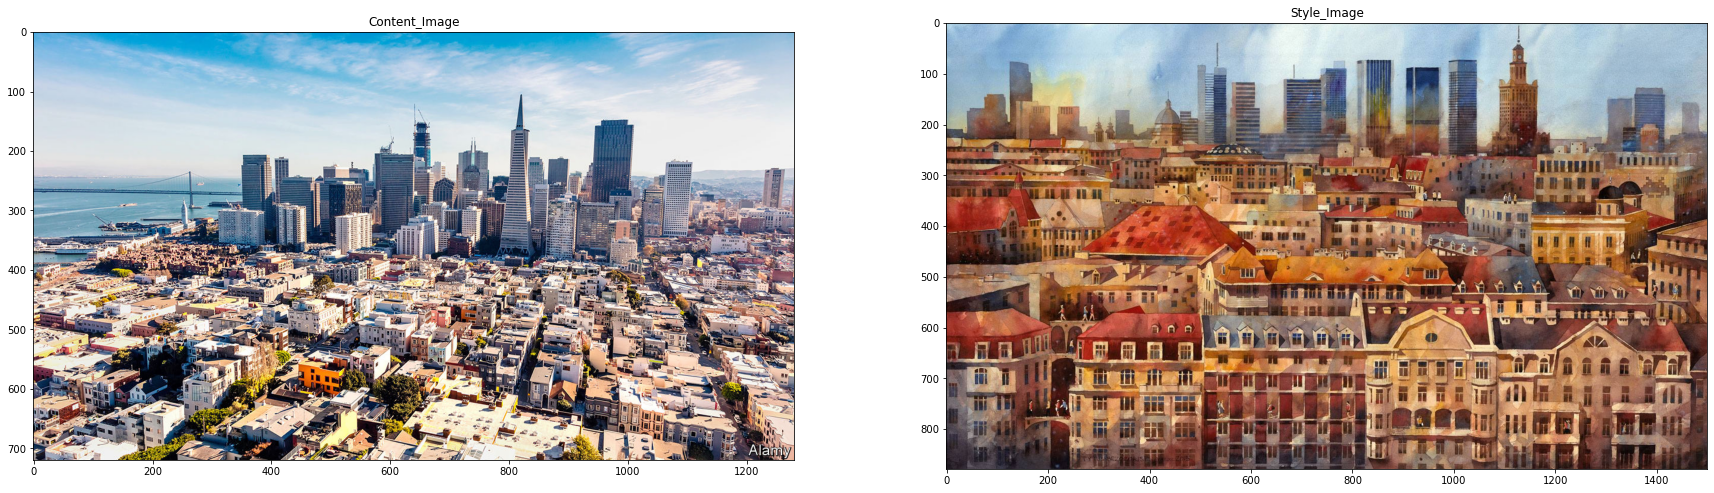

In [2]:
# Load the content and style images and visualize it
content = plt.imread('C:/Users/dhame/Style transfer/20180602_USP001_0.jpg') # taken from https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg
style = plt.imread('C:/Users/dhame/Style transfer/tytus_brzozowski_13.jpg') # taken from http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg

# PLotting of both images
fig, (x1, x2) = plt.subplots(1, 2, figsize=(30, 15))
x1.imshow(content)
x1.set_title('Content_Image')
x2.imshow(style)
x2.set_title('Style_Image')
plt.show()

In [3]:
# Making a helper funcion loading_image, which load both images into numpy array format and reshape it in 
# same size to make compatible with the model

def loading_image(image):
    image = plt.imread(image)
    img_1 = tf.image.convert_image_dtype(image, tf.float32)
    img_1= tf.image.resize(img_1, [400, 400])
    img_1 = img_1[tf.newaxis, :]
    return img_1

In [4]:
# Apply above helper function for both of the images
content = loading_image('C:/Users/dhame/Style transfer/20180602_USP001_0.jpg')
style = loading_image('C:/Users/dhame/Style transfer/tytus_brzozowski_13.jpg')

# Cross check the shapes
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

#### Loading the pre-trained VGG 19 Model from keras.application
* VGG 19 model is going to extract the features. I don't need the write for classifier beacause of pre-trained model.

In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [6]:
# checking the Network architecture of VGG19 Model, which has very big numbers of parameter
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
# Author of VGG 19 model defined specefic block names for extracting the content and style features
## For convience, we spilit layers for content and style images

content_layer = ['block4_conv2']
style_layer = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [8]:
number_content_layers = len(content_layer)
number_style_layers = len(style_layer)

In [9]:
# creating a function, which helps to extract the required features, later will be used to build custom model

def custom_extraction(layer_names, model):
    outputs = [model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

#### Gram matrix 
* The gram matrix is used to circumscribe how comparable are the features across the feature maps within one convolutional layer. This further represents non-localized learning about the image which develops the style of it. 

In [10]:
# Tensforflow makes easy to create helper function for gram matrix
def gram_matrix(tensor):
    temp = tensor
    temp = tf.squeeze(temp)
    fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(result, axis=0)
    return gram

In [11]:
# Building a custom style model using above defined custom_extraction function.This will return to 
# both content and style features.

class New_Style_Model(tf.keras.models.Model):
    def __init__(self, style_layer, content_layer):
        super(New_Style_Model, self).__init__()
        self.vgg =  custom_extraction(style_layer + content_layer, vgg)
        self.style_layer = style_layer
        self.content_layer = content_layer
        self.number_style_layers = len(style_layer)
        self.vgg.trainable = False

    def call(self, inputs):
        # Scaling back to the pixel values by multiplying with 255, pixel_values lies in (0,255)
        inputs = inputs*255.0
        # Perform preprocessing the input with VGG19
        preprocessed_inputs = preprocess_input(inputs)
        # Pass through the custom_extraction network for feature extraction
        outputs = self.vgg(preprocessed_inputs)
        # Spilit the style and content output view
        style_outputs, content_outputs = (outputs[:self.number_style_layers], outputs[self.number_style_layers:])

        # Perfrom calculation of the gram matrix for every layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # Assign the content view and respective gram matrix in a layer by layer dictonary format
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layer, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layer, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [12]:
# Use the above defined New_Style_Model to load content and style image for feature extraction
extractor = New_Style_Model(style_layer, content_layer)
content_target = extractor(content)['content']
style_target = extractor(style)['style']

In [13]:
# Optimization using Adam
optimizer = tf.optimizers.Adam(learning_rate=0.005)

In [14]:
# Defining custom weight parameter both images. Higher performace can be achieved by modifying hyperparameters
content_weight=5
style_weight=90

# Defining custom weights for every style layer
style_weights = {'block1_conv1': 1.,'block2_conv1': 0.7,'block3_conv1': 0.4,'block4_conv1': 0.2,'block5_conv1': 0.1}

In [15]:
# Defining the loss function
def loss_func(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_target[name])**2)
                           for name in style_outputs.keys()])
    # Performing normalization on style & content loss, to optimize the size of the network parameters
    style_loss *= style_weight / number_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2)
                             for name in content_outputs.keys()])
    # Performing normalization
    content_loss *= content_weight / number_content_layers
    loss = style_loss + content_loss
    return loss

#### @tf.function decorator is used to speed up the operations
* This function will :
                      
                    (a) Calculate the gradients of the loss function (here, loss_func)
                    (b) Use calculated gradients  from step (a ) to update the output (here, target) image.

In [16]:
@tf.function()
def training_time(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image) # Feature extraction 
        loss = loss_func(outputs)  # Loss calculation

    # Calculating the loss_func gradients respect to the image pixels
    gradient_loss = tape.gradient(loss, image)
    # Updating the image pixels
    optimizer.apply_gradients([(gradient_loss, image)])
    # Cliping the pixel values which falls out of [0,1]
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [17]:
# Before training starts, as target image I used the content image.
target_image = tf.Variable(content)

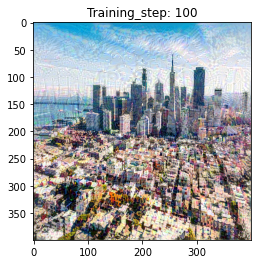

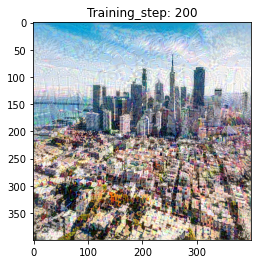

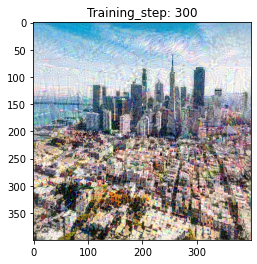

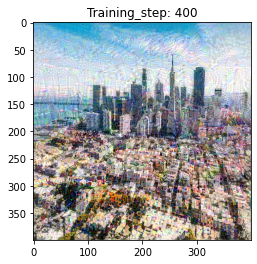

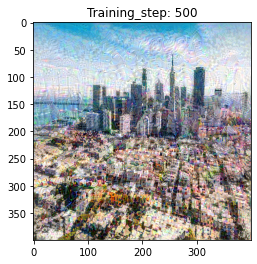

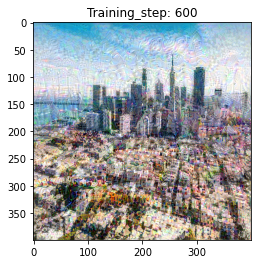

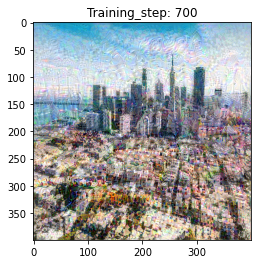

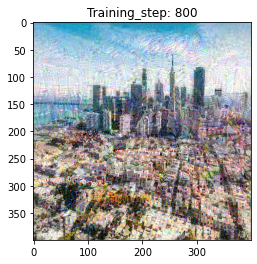

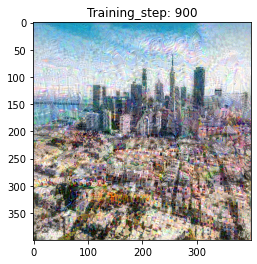

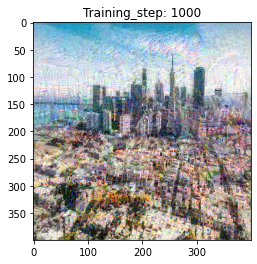

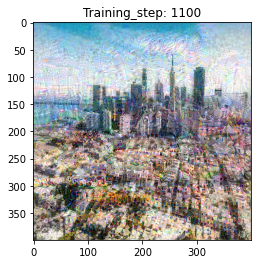

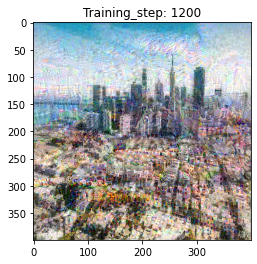

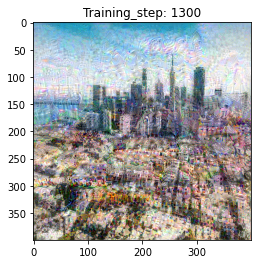

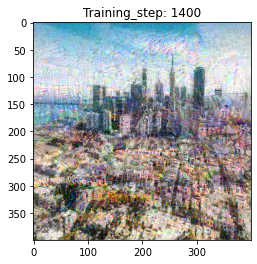

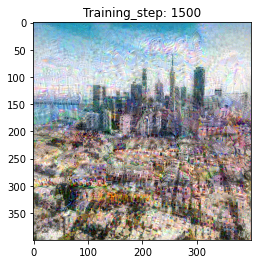

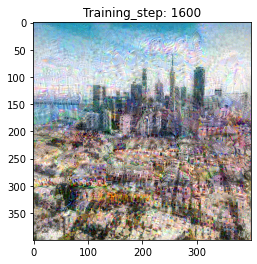

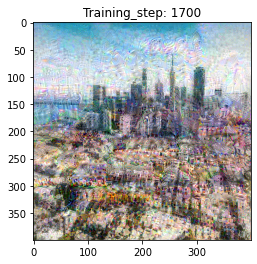

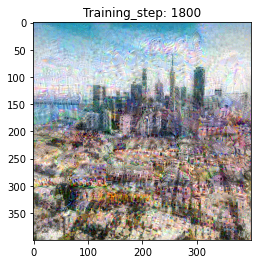

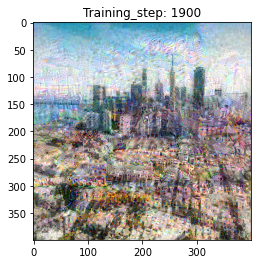

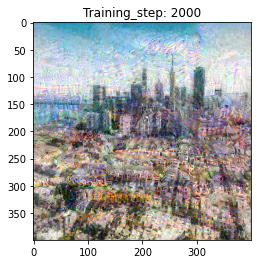

In [18]:
#Training part
epochs = 20
steps_per_epoch = 100

step = 0
for v in range(epochs):
    for d in range(steps_per_epoch):
        step += 1
        training_time(target_image)
    plt.imshow(np.squeeze(target_image.read_value(), 0))
    plt.title("Training_step: {}".format(step))
    plt.show()